# **EMAIL SPAM DETECTION**

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## **Data Preparation**

In [ ]:
### Load data to csv
data = pd.read_csv('messages.csv')

In [ ]:
### Some samples of the dataset
data.head()

subject  \
0            job posting - apple-iss research center   
1                                                NaN   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   

                                             message  label  
0  content - length : 3386 apple-iss research cen...      0  
1  lang classification grimes , joseph e . and ba...      0  
2  i am posting this inquiry for sergei atamas ( ...      0  
3  a colleague and i are researching the differin...      0  
4  earlier this morning i was on the phone with a...      0

In [ ]:
### Size of the dataset
data.shape

(2893, 3)

In [ ]:
### Messages which are note spam
data[data['label'] == 0]['message'].head(5)

0    content - length : 3386 apple-iss research cen...
1    lang classification grimes , joseph e . and ba...
2    i am posting this inquiry for sergei atamas ( ...
3    a colleague and i are researching the differin...
4    earlier this morning i was on the phone with a...
Name: message, dtype: object

In [ ]:
### Messages which are spam
data[data['label'] == 1]['message'].head(5)

21    this is a multi-part message in mime format . ...
38    note : we do not wish to send e-mail to anyone...
84    just released . . . 30 , 000 , 000 email addre...
85    hi , would you like to earn an extra $ 700 a w...
86    this is really cool ! premium channels and pay...
Name: message, dtype: object

In [ ]:
### Distribution of class labels
data.label.value_counts()/len(data)*100

0    83.373661
1    16.626339
Name: label, dtype: float64

In [ ]:
### Check for null values
data.isnull().sum()

subject    62
message     0
label       0
dtype: int64

We have null values in the subject column. For features we are considering only the content of the message so we can ignore the subject column

## **Data cleaning and feature engineering**

In [ ]:
### IMport required libraries for cleaning
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
### Cleaning data
corpus = []
for i in range(len(data)):
    
    
    ### Relace email ids with emailaddress
    review = re.sub(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress',data.loc[i,'message'])
    
    ### Select data with only alphabets
    
    review = re.sub('[^a-zA-Z]',' ',data['message'][i])
    
    ### Replace more than one spaces with single space
    review = re.sub(r'\s+', ' ',review)
    
    ### convert the document to lowercase 
    review = review.lower()
    
    ### Append the document in a list
    corpus.append(review)

In [ ]:
### Stemming
ps = PorterStemmer()
for i in range(len(corpus)):
    review = word_tokenize(corpus[i])
    
    ### Remove stop words
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    
    ### Join list of words
    review = ' '.join(review)
    corpus[i] = review

In [ ]:
### Create column for adding cleaned document length and weights
data['clean_legnth'] = [len(i) for i in corpus]
data['clean_words'] = [len(i.split()) for i in corpus]

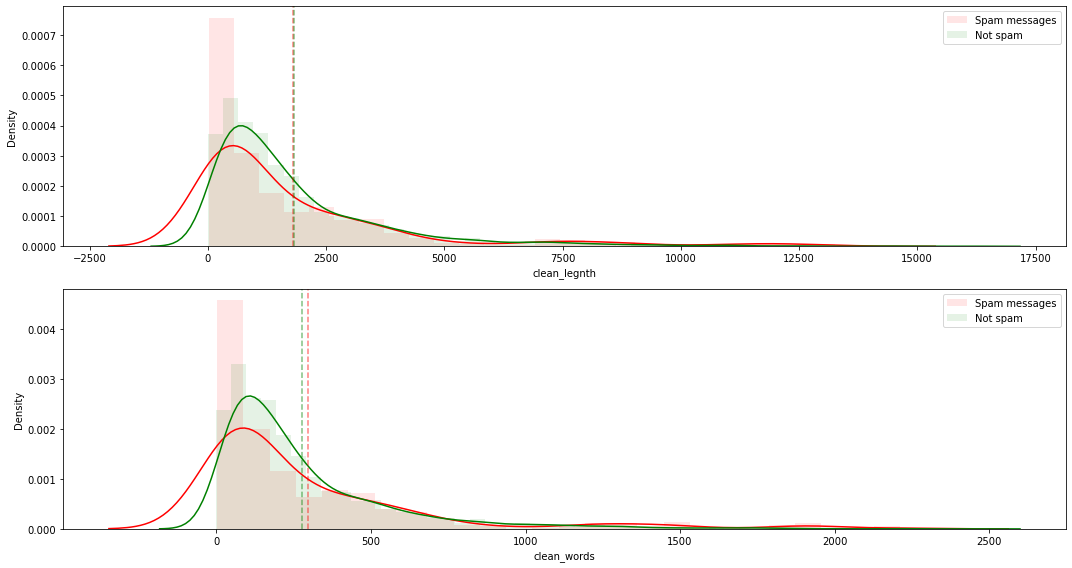

In [ ]:
### Plot graphs for clean  length and clean words
plt.figure(figsize=(15,8))

plt.subplot(2,1,1)
sns.distplot(data[data['label'] == 1]['clean_legnth'],color='r', label='Spam messages',hist_kws={'alpha':0.1})
sns.distplot(data[data['label'] == 0]['clean_legnth'],color='g', label='Not spam',hist_kws={'alpha':0.1})
plt.axvline(data[data['label'] == 1]['clean_legnth'].mean(),color='r',linestyle='--',alpha=0.5)
plt.axvline(data[data['label'] == 0]['clean_legnth'].mean(),color='g',linestyle='--',alpha=0.5)
plt.legend()

plt.subplot(2,1,2)
sns.distplot(data[data['label'] == 1]['clean_words'],color='r', label='Spam messages',hist_kws={'alpha':0.1})
sns.distplot(data[data['label'] == 0]['clean_words'],color='g', label='Not spam',hist_kws={'alpha':0.1})
plt.axvline(data[data['label'] == 1]['clean_words'].mean(),color='r',linestyle='--',alpha=0.5)
plt.axvline(data[data['label'] == 0]['clean_words'].mean(),color='g',linestyle='--',alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
### Creat word dictionary and convert to trainable features
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=6000)
x = cv.fit_transform(corpus).toarray()

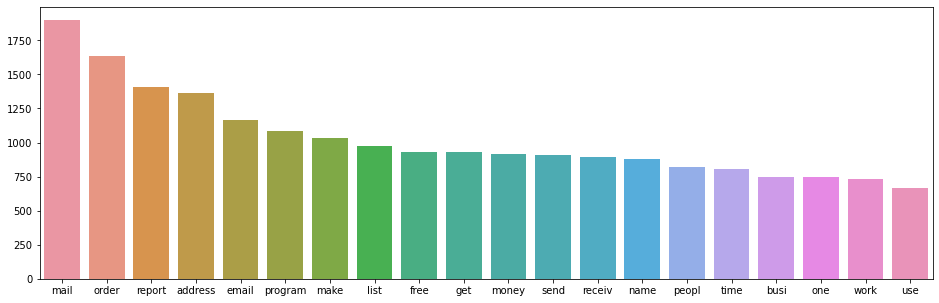

In [ ]:
df = pd.DataFrame(x,columns=cv.get_feature_names())
df = df.iloc[data[data['label'] == 1].index].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(16,5))
sns.barplot(x=df.index,y=df.values)
plt.show()

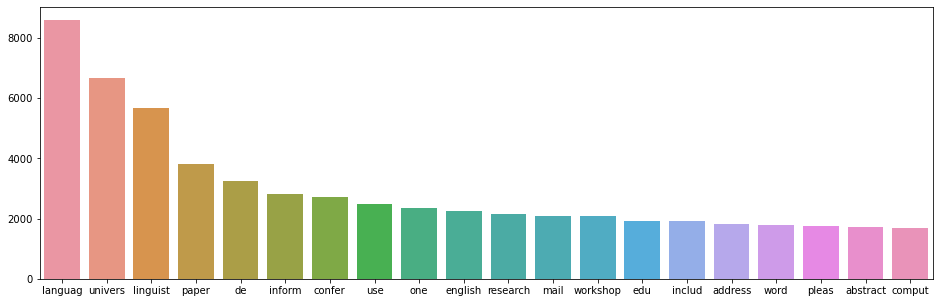

In [ ]:
df = pd.DataFrame(x,columns=cv.get_feature_names())
df = df.iloc[data[data['label'] == 0].index].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(16,5))
sns.barplot(x=df.index,y=df.values)
plt.show()

## **Training model and Evaluation**

In [ ]:
### Split data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,data['label'],test_size=0.2,random_state=40,stratify=data['label'])

In [ ]:
### Import models and metrics for measuring performances
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

Training score :  0.993085566119274


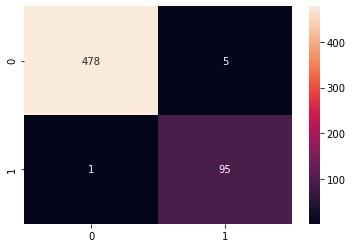

              precision    recall  f1-score   support

           0      0.998     0.990     0.994       483
           1      0.950     0.990     0.969        96

    accuracy                          0.990       579
   macro avg      0.974     0.990     0.982       579
weighted avg      0.990     0.990     0.990       579



In [ ]:
### Multinomial Naive Bayes
spam_model = MultinomialNB().fit(x_train, y_train)
print('Training score : ',spam_model.score(x_train, y_train))
y_pred = spam_model.predict(x_test)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.show()
print(classification_report(y_test,y_pred,digits=3))

No Skill: ROC AUC=0.500
Multinomial NB: ROC AUC=0.998


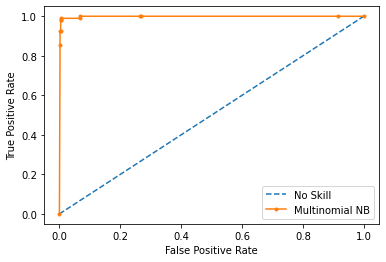

In [ ]:
### Roc Auc Curve
lr_probs = spam_model.predict_proba(x_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Multinomial NB: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Multinomial NB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Training score :  0.9917891097666378


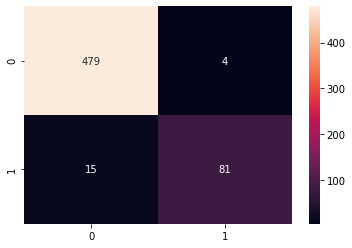

              precision    recall  f1-score   support

           0      0.970     0.992     0.981       483
           1      0.953     0.844     0.895        96

    accuracy                          0.967       579
   macro avg      0.961     0.918     0.938       579
weighted avg      0.967     0.967     0.966       579



In [ ]:
### Gaussian Naive Bayes
spam_model = GaussianNB().fit(x_train, y_train)
print('Training score : ',spam_model.score(x_train, y_train))
y_pred = spam_model.predict(x_test)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.show()
print(classification_report(y_test,y_pred,digits=3))

No Skill: ROC AUC=0.500
Multinomial NB: ROC AUC=0.918


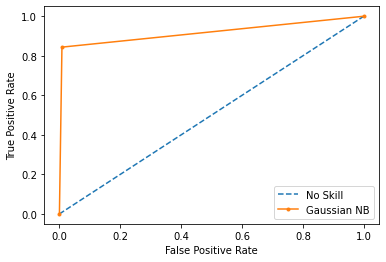

In [ ]:
### Roc Auc Curve
lr_probs = spam_model.predict_proba(x_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Multinomial NB: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Gaussian NB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Training score :  0.9844425237683665


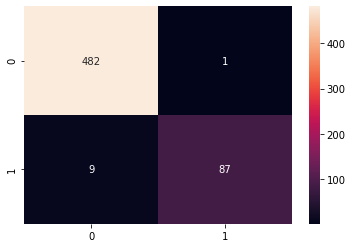

              precision    recall  f1-score   support

           0      0.982     0.998     0.990       483
           1      0.989     0.906     0.946        96

    accuracy                          0.983       579
   macro avg      0.985     0.952     0.968       579
weighted avg      0.983     0.983     0.982       579



In [ ]:
### Bernoulli Naive Bayes
spam_model = BernoulliNB().fit(x_train, y_train)
print('Training score : ',spam_model.score(x_train, y_train))
y_pred = spam_model.predict(x_test)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')
plt.show()
print(classification_report(y_test,y_pred,digits=3))

No Skill: ROC AUC=0.500
Multinomial NB: ROC AUC=0.999


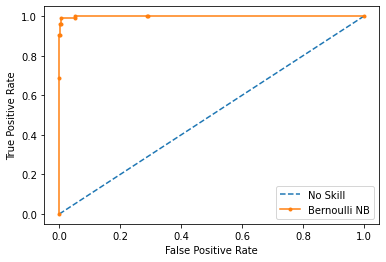

In [ ]:
lr_probs = spam_model.predict_proba(x_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Multinomial NB: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Bernoulli NB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()